In [19]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [20]:
import os

path = os.listdir('C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Training')
classes = {'no_tumor':0, 'pituitary_tumor':1}

In [21]:
import cv2
import os

X = []
Y = []
base_path = 'C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Training'

for cls in classes:
    pth = os.path.join(base_path, cls)  # Corrected path construction
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j), 0)
        img = cv2.resize(img, (200,200))
        X.append(img)
        Y.append(classes[cls])


In [22]:
X = np.array(X)
Y = np.array(Y)

X_updated = X.reshape(len(X), -1)


In [23]:
np.unique(Y)

array([0, 1])

In [6]:
pd.Series(Y).value_counts()

1    827
0    395
Name: count, dtype: int64

In [7]:
X.shape, X_updated.shape

((1222, 200, 200), (1222, 40000))

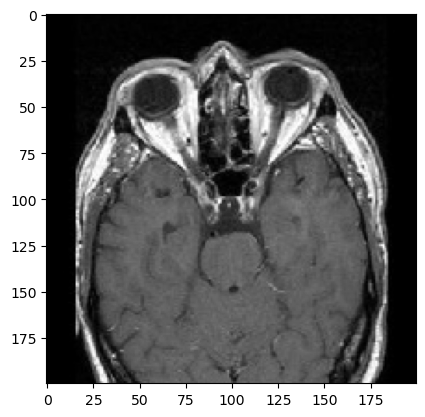

In [8]:
plt.imshow(X[0], cmap='gray')

In [9]:

X_updated = X.reshape(len(X), -1)
X_updated.shape

(1222, 40000)

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,
                                               test_size=.20)

In [11]:
xtrain.shape, xtest.shape

((977, 40000), (245, 40000))

In [12]:
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain/255
xtest = xtest/255
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())


255 0
255 0
1.0 0.0
1.0 0.0


In [13]:
from sklearn.decomposition import PCA

In [14]:
print(xtrain.shape, xtest.shape)

pca = PCA(.98)
# pca_train = pca.fit_transform(xtrain)
# pca_test = pca.transform(xtest)
pca_train = xtrain
pca_test = xtest

(977, 40000) (245, 40000)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
import warnings
warnings.filterwarnings('ignore')

lg = LogisticRegression(C=0.1)
lg.fit(xtrain, ytrain)


In [ ]:
sv = SVC()
sv.fit(xtrain, ytrain)

In [ ]:
print("Training Score:", lg.score(xtrain, ytrain))
print("Testing Score:", lg.score(xtest, ytest))

In [72]:
print("Training Score:", sv.score(xtrain, ytrain))
print("Testing Score:", sv.score(xtest, ytest))

Training Score: 0.9938587512794268
Testing Score: 0.963265306122449


In [73]:
pred = sv.predict(xtest)

In [74]:
misclassified=np.where(ytest!=pred)
misclassified

(array([ 36,  51,  68, 120, 212, 214, 220, 227, 239], dtype=int64),)

In [75]:
print("Total Misclassified Samples: ",len(misclassified[0]))
print(pred[36],ytest[36])

Total Misclassified Samples:  9
0 1


In [76]:
dec = {0:'No Tumor', 1:'Positive Tumor'}

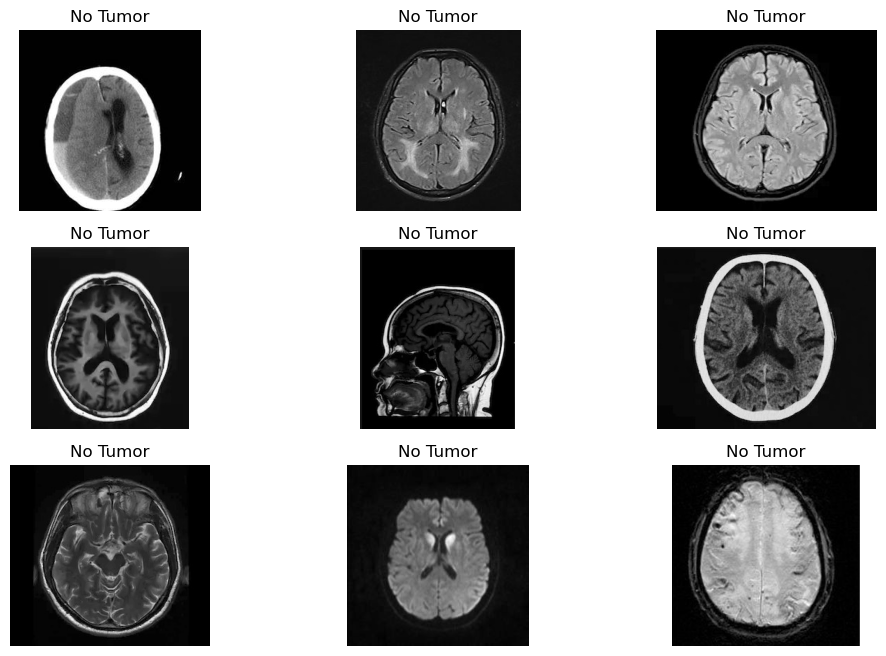

In [77]:
plt.figure(figsize=(12,8))
p = os.listdir('C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Testing\\')
c=1
for i in os.listdir('C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Testing\\no_tumor\\')[:9]:
    plt.subplot(3,3,c)
    
    img = cv2.imread('C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Testing\\no_tumor\\'+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1


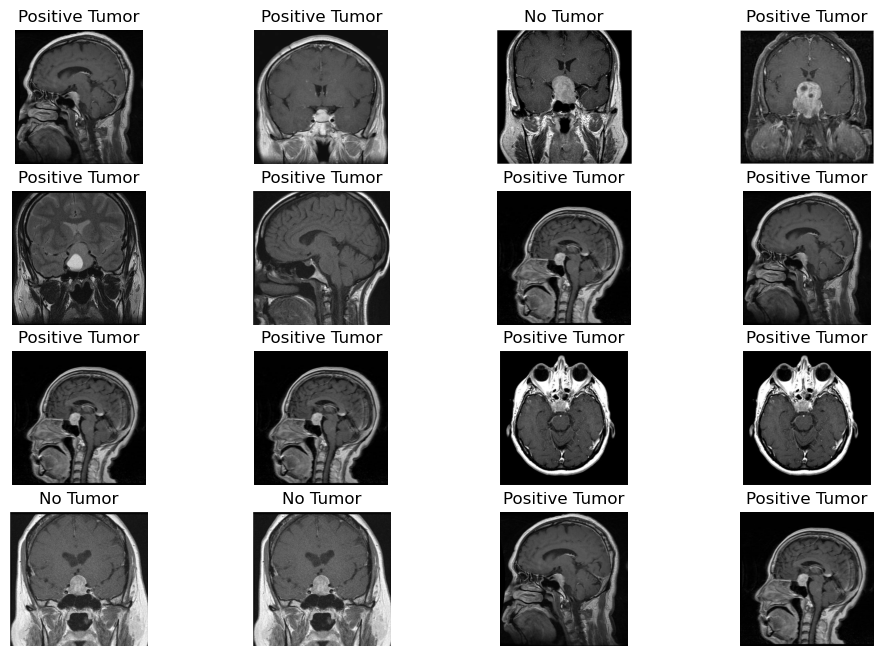

In [78]:
plt.figure(figsize=(12,8))
p = os.listdir('C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Testing\\')
c=1
for i in os.listdir('C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Testing\\pituitary_tumor\\')[:16]:
    plt.subplot(4,4,c)
    
    img = cv2.imread('C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Testing\\pituitary_tumor\\'+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1


In [79]:
import numpy as np
import cv2
import pywt
from heapq import heappush, heappop, heapify
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings


In [80]:
# Suppress warnings for brevity
warnings.filterwarnings('ignore')


In [81]:
# Function to perform Huffman coding
def huffman_coding(data):
    freq = {}
    for d in data:
        freq[d] = freq.get(d, 0) + 1

    heap = [[weight, [symbol, ""]] for symbol, weight in freq.items()]
    heapify(heap)

    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    return dict(sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p)))

In [82]:
# Function to compress image using Huffman coding
def compress_image(image):
    data = image.ravel()
    code_dict = huffman_coding(data)
    compressed_data = ''.join(code_dict[d] for d in data)
    return compressed_data, code_dict

In [83]:
# Function to reconstruct image using IDWT
def reconstruct_image(compressed_data, code_dict, shape):
    reverse_dict = {v: k for k, v in code_dict.items()}
    bits = ''
    decoded_data = []
    for bit in compressed_data:
        bits += bit
        if bits in reverse_dict:
            decoded_data.append(reverse_dict[bits])
            bits = ''
    decoded_data = np.array(decoded_data).reshape(shape)
    return decoded_data


In [84]:
# Load and preprocess data for tumor identification
path = 'C:\\Users\\Microsoft\\Downloads\\Image Compression Web\\Training\\'
classes = {'no_tumor': 0, 'pituitary_tumor': 1}

In [85]:
X = []
Y = []
for cls in classes:
    pth = path + cls
    for j in os.listdir(pth):
        img = cv2.imread(pth + '/' + j, 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])
        
X = np.array(X)
Y = np.array(Y)



In [86]:
# Split data
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=10, test_size=.20)

In [87]:
# Train model for tumor identification
svc = SVC()
svc.fit(xtrain.reshape(len(xtrain), -1), ytrain)

SVC()

In [88]:
# Identify tumors in the test set
identified_tumor_images = xtest[svc.predict(xtest.reshape(len(xtest), -1)) == 1]

In [89]:
# Compression
compressed_images = []
code_dicts = []
for image in identified_tumor_images:
    compressed_data, code_dict = compress_image(image)
    compressed_images.append(compressed_data)
    code_dicts.append(code_dict)

In [90]:
def reconstruct_image(compressed_data, code_dict, original_shape):
    reverse_dict = {v: k for k, v in code_dict.items()}
    bits = ''
    decoded_data = []
    for bit in compressed_data:
        bits += bit
        if bits in reverse_dict:
            decoded_data.append(reverse_dict[bits])
            bits = ''
    decoded_data = np.array(decoded_data)
    reconstructed_image = decoded_data.reshape(original_shape)
    return reconstructed_image


In [91]:
# Assuming you have labels for the test set (ytest)
# Assuming reconstructed_images contains the reconstructed tumor images

# Convert reconstructed images to the same shape as the original test images
original_shape = xtest.shape[1:]
reconstructed_images_resized = [cv2.resize(img, original_shape[::-1]) for img in reconstructed_images]

# Evaluate the model on the reconstructed images
if flattened_reconstructed_images:
    reconstructed_predictions = svc.predict(flattened_reconstructed_images)
    # Compare reconstructed predictions with the true labels from ytest
    evaluation_report = classification_report(ytest, reconstructed_predictions)
    print(evaluation_report)
else:
    print("No reconstructed images to evaluate.")


No reconstructed images to evaluate.


In [92]:
print("Number of identified tumor images:", len(identified_tumor_images))
print("Number of compressed images:", len(compressed_images))
print("Number of reconstructed images:", len(reconstructed_images))


Number of identified tumor images: 167
Number of compressed images: 167
Number of reconstructed images: 0


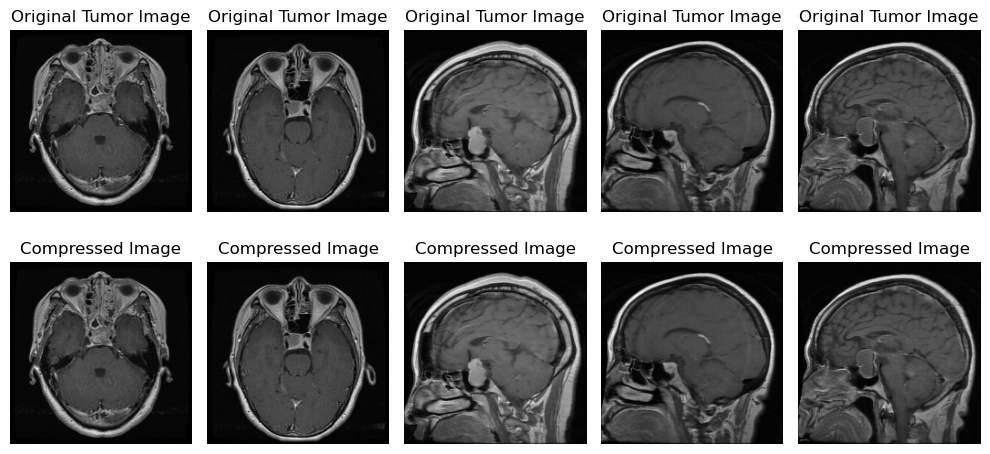

In [93]:
import matplotlib.pyplot as plt

# Display the identified tumor images and their compressed versions
num_images_to_display = min(5, len(identified_tumor_images))  # Adjust the number of images to display as needed

plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    # Original tumor image
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(identified_tumor_images[i], cmap='gray')
    plt.title('Original Tumor Image')
    plt.axis('off')

    # Compressed image
    compressed_img = reconstruct_image(compressed_images[i], code_dicts[i], identified_tumor_images[i].shape)
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(compressed_img, cmap='gray')
    plt.title('Compressed Image')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [95]:
# Calculate sizes of original and compressed images
original_sizes = [img.nbytes for img in identified_tumor_images]  # Sizes of original tumor images in bytes
compressed_sizes = [len(compressed_data) for compressed_data in compressed_images]  # Sizes of compressed images in bits

# Convert compressed sizes from bits to bytes
compressed_sizes_bytes = [size / 8 for size in compressed_sizes]

# Compute compression ratio as a percentage
compression_ratios = [(1 - (compressed_size / original_size)) * 100 for original_size, compressed_size in zip(original_sizes, compressed_sizes_bytes)]

# Display the comparison
for i in range(len(identified_tumor_images)):
    print(f"Image {i + 1}:")
    print(f"Original size: {original_sizes[i]} bytes")
    print(f"Compressed size: {compressed_sizes_bytes[i]:.2f} bytes")
    print(f"Compression ratio: {compression_ratios[i]:.2f}%")
    print()


Image 1:
Original size: 40000 bytes
Compressed size: 31020.12 bytes
Compression ratio: 22.45%

Image 2:
Original size: 40000 bytes
Compressed size: 29405.12 bytes
Compression ratio: 26.49%

Image 3:
Original size: 40000 bytes
Compressed size: 35362.50 bytes
Compression ratio: 11.59%

Image 4:
Original size: 40000 bytes
Compressed size: 32811.50 bytes
Compression ratio: 17.97%

Image 5:
Original size: 40000 bytes
Compressed size: 33225.62 bytes
Compression ratio: 16.94%

Image 6:
Original size: 40000 bytes
Compressed size: 33134.88 bytes
Compression ratio: 17.16%

Image 7:
Original size: 40000 bytes
Compressed size: 27090.88 bytes
Compression ratio: 32.27%

Image 8:
Original size: 40000 bytes
Compressed size: 33821.50 bytes
Compression ratio: 15.45%

Image 9:
Original size: 40000 bytes
Compressed size: 33396.38 bytes
Compression ratio: 16.51%

Image 10:
Original size: 40000 bytes
Compressed size: 29049.25 bytes
Compression ratio: 27.38%

Image 11:
Original size: 40000 bytes
Compressed s

In [96]:
# Check if compressed image retains tumor
for i in range(len(compressed_images)):
    # Reconstruct compressed image
    reconstructed_image = reconstruct_image(compressed_images[i], code_dicts[i], identified_tumor_images[i].shape)
    
    # Flatten the reconstructed image
    flattened_reconstructed_image = reconstructed_image.ravel()
    
    # Predict presence of tumor in the reconstructed image
    reconstructed_prediction = svc.predict([flattened_reconstructed_image])[0]
    
    # Print result
    print(f"Compressed image {i + 1}:")
    if reconstructed_prediction == 1:
        print("Tumor is present")
    else:
        print("Tumor is not present")


Compressed image 1:
Tumor is present
Compressed image 2:
Tumor is present
Compressed image 3:
Tumor is present
Compressed image 4:
Tumor is present
Compressed image 5:
Tumor is present
Compressed image 6:
Tumor is present
Compressed image 7:
Tumor is present
Compressed image 8:
Tumor is present
Compressed image 9:
Tumor is present
Compressed image 10:
Tumor is present
Compressed image 11:
Tumor is present
Compressed image 12:
Tumor is present
Compressed image 13:
Tumor is present
Compressed image 14:
Tumor is present
Compressed image 15:
Tumor is present
Compressed image 16:
Tumor is present
Compressed image 17:
Tumor is present
Compressed image 18:
Tumor is present
Compressed image 19:
Tumor is present
Compressed image 20:
Tumor is present
Compressed image 21:
Tumor is present
Compressed image 22:
Tumor is present
Compressed image 23:
Tumor is present
Compressed image 24:
Tumor is present
Compressed image 25:
Tumor is present
Compressed image 26:
Tumor is present
Compressed image 27:
